# Particle Swarn Optimization (PSO) Algorithm

**Inputs**  

| Name | Description |
|--------------|------|
| `n_particles` | swarm size (number of particles) |
| `w`           | inertia weight – fraction of previous velocity retained |
| `b1`          | cognitive coefficient – pull toward each particle’s own best position |
| `b2`          | social coefficient – pull toward the global best position |
| `n_iterations`| total number of optimisation steps |

**Output**  
`best_val`, `best_pos` — the lowest objective value found and its coordinates.

---

### Algorithm (2-D pseudo-code)

```pseudo
Initialise an empty swarm P
for i = 1 … n_particles do
    x_i ← random position within bounds
    v_i ← random initial velocity
    pbest_i ← x_i
    P ← P ∪ { (x_i , v_i , pbest_i) }
end for
gbest ← argmin_pbest P                // global best position so far

repeat n_iterations times
    for each particle (x, v, pbest) in P do
        // --- velocity update ---
        r1, r2 ← Uniform(0, 1)
        v ← w * v
            + b1 * r1 * (pbest − x)
            + b2 * r2 * (gbest − x)

        // --- position update ---
        x ← x + v
        clip x to bounds

        // --- evaluate & update personal/global bests ---
        if f(x) < f(pbest) then
            pbest ← x
            if f(x) < f(gbest) then
                gbest ← x
            end if
        end if
    end for
end repeat

return gbest, f(gbest)


In [153]:
from __future__ import annotations

# ── Standard library ────────────────────────────────────────────────────────────
import html
import itertools
import json
import math
import re
from pathlib import Path
from typing import Any

# ── Third-party libraries ───────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation

# Benchmark Functions for Continuous Optimization 
#### Implementations in 2-D

## 1. Sphere Function

**Definition**  
$$
f(\mathbf{x}) = \sum_{i=1}^{d} x_i^2
$$

**Global Optimum**  
$$
\mathbf{x}^* = \mathbf{0}, \quad f(\mathbf{0}) = 0
$$

In [154]:
def sphere_2d(pos):
    x, y = pos
    return x**2 + y**2  

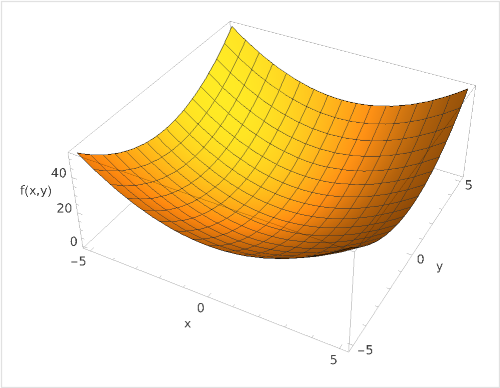

## 2. Rastrigin Function

**Definition**  
$$
f(\mathbf{x}) = 10\,d \;+\; \sum_{i=1}^{d} \bigl(x_i^2 - 10\cos(2\pi x_i)\bigr)
$$

**Global Optimum**  
$$
\mathbf{x}^* = \mathbf{0}, \quad f(\mathbf{0}) = 0
$$

In [155]:
def rastrigin(pos):
    x, y = pos
    return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

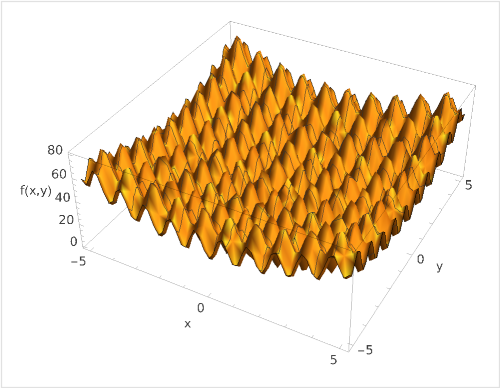

## 3. Rosenbrock (“Banana”) Function

**Definition**  
$$
f(\mathbf{x}) = \sum_{i=1}^{d-1} \Bigl[\,100\,(x_{i+1} - x_i^2)^2 + (1 - x_i)^2\Bigr]
$$

**Global Optimum**  
$$
\mathbf{x}^* = (1,1,\dots,1), \quad f(\mathbf{x}^*) = 0
$$

In [156]:
def rosenbrock(pos, a: float = 1.0, b: float = 100.0):
    x, y = pos
    return (a - x) ** 2 + b * (y - x ** 2) ** 2

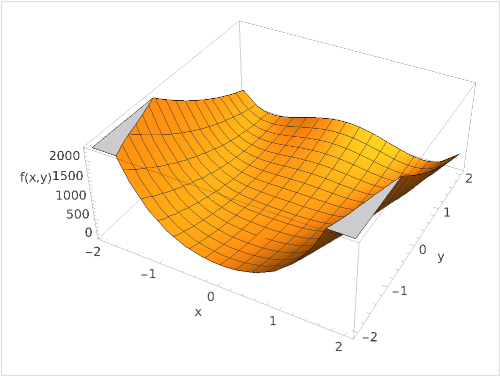

## 4. Ackley Function

**Definition**  
$$
f(\mathbf{x}) =
-20 \exp\!\Bigl(-0.2 \sqrt{\tfrac{1}{d}\sum_{i=1}^{d} x_i^2}\Bigr)
- \exp\!\Bigl(\tfrac{1}{d}\sum_{i=1}^{d} \cos(2\pi x_i)\Bigr)
+ 20 + e
$$

**Global Optimum**  
$$
\mathbf{x}^* = \mathbf{0}, \quad f(\mathbf{0}) = 0
$$

In [157]:
def ackley(pos):
    x, y = pos
    a, b, c = 20, 0.2, 2 * np.pi
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + math.e

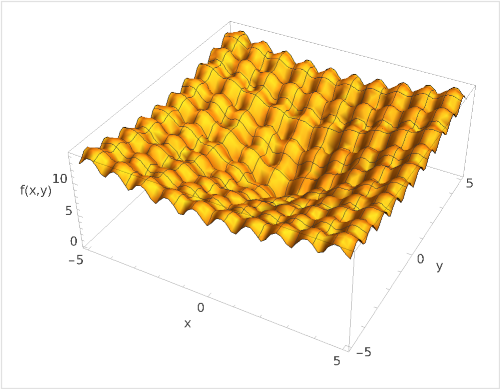

In [160]:
# Dictionary of 2D objective functions
OBJECTIVES_2D = {
    "sphere": sphere_2d,
    "rastrigin": rastrigin,
    "ackley": ackley,
    "rosenbrock": rosenbrock,
}
# known global minima (value) for reporting convenience
ACTUAL_BEST_VAL = {name: 0.0 for name in OBJECTIVES_2D}

# PSO implementation (with animation)

In [161]:
def animate_pso(
    obj_name: str = "sphere",
    *,
    n_particles: int = 30,
    n_iterations: int = 100,
    w: float = 0.7,
    b1: float = 1.4,
    b2: float = 1.4,
    bounds: tuple[float, float] = (-10, 10),
    seed: int | None = None,
    interval: int = 50,
    close_fig: bool = True,
):
    """Return (FuncAnimation, best_position, best_value)."""

    if obj_name not in OBJECTIVES_2D:
        raise ValueError(f"Unknown objective '{obj_name}'.")
    f = OBJECTIVES_2D[obj_name]
    rng = np.random.default_rng(seed)

    class Particle:
        def __init__(self):
            self.position = rng.uniform(*bounds, size=2)
            self.velocity = rng.uniform(-1, 1, size=2)
            self.best_pos = self.position.copy()
            self.best_val = f(self.position)

        def step(self, gbest):
            r1, r2 = rng.random(2)
            self.velocity = (
                w * self.velocity
                + b1 * r1 * (self.best_pos - self.position)
                + b2 * r2 * (gbest - self.position)
            )
            self.position += self.velocity
            self.position = np.clip(self.position, *bounds)
            val = f(self.position)
            if val < self.best_val:
                self.best_val, self.best_pos = val, self.position.copy()
            return val

    # init swarm
    particles = [Particle() for _ in range(n_particles)]
    gbest = min(particles, key=lambda p: p.best_val).best_pos.copy()

    # background contour
    grid = np.linspace(*bounds, 300)
    X, Y = np.meshgrid(grid, grid)
    Z = f((X, Y))

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_xlim(*bounds); ax.set_ylim(*bounds)
    ax.contourf(X, Y, Z, levels=40, cmap="viridis", alpha=0.6)
    scatter = ax.scatter([], [], c="black", s=35)
    (gbest_marker,) = ax.plot([], [], "rx", markersize=12, markeredgewidth=2)

    def init():
        scatter.set_offsets(np.empty((0, 2)))
        gbest_marker.set_data([], [])
        return scatter, gbest_marker

    def update(frame):
        nonlocal gbest
        for p in particles:
            val = p.step(gbest)
            if val < f(gbest):
                gbest = p.best_pos.copy()
        scatter.set_offsets(np.vstack([p.position for p in particles]))
        gbest_marker.set_data([gbest[0]], [gbest[1]])
        ax.set_title(
            f"{obj_name} | iter {frame+1}/{n_iterations} | best = {f(gbest):.2e}"
        )
        return scatter, gbest_marker

    ani = FuncAnimation(fig, update, frames=n_iterations, init_func=init,
                        blit=True, interval=interval, repeat=False)
    if close_fig:
        plt.close(fig)
    return ani, gbest.copy(), float(f(gbest))

### Implementation for parameters grid

In [162]:
def run_grid(
    param_grid: dict[str, list[Any]],
    *,
    save_dir: str | Path = "runs",
    bounds: tuple[float, float] = (-10, 10),
    seed: int | None = 42,
    make_gif: bool = True,
    fps: int = 30,                          
) -> pd.DataFrame:
    # ----------------------------------------------------------------------
    required = {"n_particles", "n_iterations", "w", "b1", "b2"}
    missing  = required - param_grid.keys()
    if missing:
        raise ValueError(f"param_grid missing required keys: {missing}")

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    rows: list[dict[str, Any]] = []
    combos = list(itertools.product(*param_grid.values()))
    keys   = list(param_grid)

    for func_name, (combo_idx, combo_vals) in itertools.product(
        OBJECTIVES_2D, enumerate(combos)
    ):
        params   = dict(zip(keys, combo_vals))
        run_seed = None if seed is None else seed + combo_idx

        # — run optimisation (and maybe record GIF) —-----------------------
        ani, best_pos, best_val = animate_pso(
            func_name,
            n_particles=params["n_particles"],
            n_iterations=params["n_iterations"],
            w=params["w"], b1=params["b1"], b2=params["b2"],
            bounds=bounds, seed=run_seed,
            close_fig=not make_gif,
        )

        if make_gif:
            gif_name = (
                f"{func_name}_idx{combo_idx}_w{params['w']}_b1{params['b1']}_"
                f"b2{params['b2']}_p{params['n_particles']}_n{params['n_iterations']}.gif"
            )
            ani.save(save_dir / gif_name, writer="pillow", fps=fps)  # ← uses fps
            plt.close(ani._fig)

        # — record row —----------------------------------------------------
        row = {
            "function": func_name,
            "best_pos": json.dumps(best_pos.tolist()),
            "best_val": best_val,
            "actual_best": ACTUAL_BEST_VAL[func_name],
        }
        row.update(params)
        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(save_dir / "grid_results.csv", index=False)
    return df


# Param grid run

| Parameter | Usual range | ↓ smaller / ↑ larger effect |
|-----------------------------|-------------|-----------------------------|
| **`n_particles`** | **10 – 100** (int) | ↓ cheaper per iter, less diversity • ↑ better global exploration, cost ∝ *n* |
| **`n_iterations`** | **50 – 2000** (int) | ↓ may stop before convergence • ↑ linear runtime growth |
| **`w`** (inertia) | **0.3 – 0.9** | ↓ quick damping ➜ exploitation • ↑ more momentum ➜ exploration/oscillation |
| **`b1`** (cognitive) | **0 – 3** | ↓ weak self-pull • ↑ strong pull to personal best (can reduce diversity) |
| **`b2`** (social) | **0 – 3** | ↓ slow collective convergence • ↑ fast clustering (risk of local optima)

In [178]:
grid = {
    "n_particles": [8, 20],
    "n_iterations": [20, 40],
    "w": [0.4, 0.7],
    "b1": [0.5, 1.5],
    "b2": [0.5, 1.5],
}

df = run_grid(grid, save_dir="grid_run", fps=60, make_gif=True)
df["best_pos"] = df["best_pos"].apply(lambda s: json.dumps([round(v, 3) for v in json.loads(s)]))

sort_cols  = ["n_iterations", "best_val"]
df_sorted  = df.sort_values(sort_cols, ascending=[True, True])

In [179]:
# Slice out the four functions
df_sphere     = df_sorted[df_sorted["function"] == "sphere"]
df_rastrigin  = df_sorted[df_sorted["function"] == "rastrigin"]
df_rosenbrock = df_sorted[df_sorted["function"] == "rosenbrock"]
df_ackley     = df_sorted[df_sorted["function"] == "ackley"]

In [180]:
# Top results for each function and each n_iterations
cols = ["n_particles", "n_iterations", "w", "b1", "b2", "best_val"]
dfs  = [df_sphere, df_rastrigin, df_rosenbrock, df_ackley]

for d in dfs:
    func_name = d["function"].iloc[0]
    print(f"\nFunction: {func_name}")
    print("-" * 60)

    # iterate over n_iterations values in descending order (largest first)
    for n_iter in sorted(d["n_iterations"].unique(), reverse=True):
        sub = d[d["n_iterations"] == n_iter]
        print(f"n_iterations = {n_iter}")
        display(sub[cols].head())      # show up to the first 5 rows for this n_iter



Function: sphere
------------------------------------------------------------
n_iterations = 40


,n_particles,n_iterations,w,b1,b2,best_val
26,20,40,0.4,1.5,0.5,0.187119
28,20,40,0.7,0.5,0.5,0.771049
13,8,40,0.7,0.5,1.5,2.084134
9,8,40,0.4,0.5,1.5,2.474353
27,20,40,0.4,1.5,1.5,2.872300


n_iterations = 20


,n_particles,n_iterations,w,b1,b2,best_val
20,20,20,0.7,0.5,0.5,0.702309
22,20,20,0.7,1.5,0.5,2.123431
21,20,20,0.7,0.5,1.5,2.421566
3,8,20,0.4,1.5,1.5,2.463935
23,20,20,0.7,1.5,1.5,2.516617



Function: rastrigin
------------------------------------------------------------
n_iterations = 40


,n_particles,n_iterations,w,b1,b2,best_val
45,8,40,0.7,0.5,1.5,15.878807
42,8,40,0.4,1.5,0.5,16.639511
60,20,40,0.7,0.5,0.5,17.226330
63,20,40,0.7,1.5,1.5,20.354092
41,8,40,0.4,0.5,1.5,22.522468


n_iterations = 20


,n_particles,n_iterations,w,b1,b2,best_val
55,20,20,0.7,1.5,1.5,11.212325
54,20,20,0.7,1.5,0.5,17.666982
38,8,20,0.7,1.5,0.5,19.840003
50,20,20,0.4,1.5,0.5,20.260753
33,8,20,0.4,0.5,1.5,21.678280



Function: rosenbrock
------------------------------------------------------------
n_iterations = 40


,n_particles,n_iterations,w,b1,b2,best_val
127,20,40,0.7,1.5,1.5,5.877553
110,8,40,0.7,1.5,0.5,11.265009
122,20,40,0.4,1.5,0.5,13.452264
124,20,40,0.7,0.5,0.5,21.165958
126,20,40,0.7,1.5,0.5,114.621070


n_iterations = 20


,n_particles,n_iterations,w,b1,b2,best_val
115,20,20,0.4,1.5,1.5,3.508218
116,20,20,0.7,0.5,0.5,4.473782
99,8,20,0.4,1.5,1.5,8.678045
114,20,20,0.4,1.5,0.5,143.722324
117,20,20,0.7,0.5,1.5,218.788261



Function: ackley
------------------------------------------------------------
n_iterations = 40


,n_particles,n_iterations,w,b1,b2,best_val
90,20,40,0.4,1.5,0.5,3.075571
92,20,40,0.7,0.5,0.5,3.859975
77,8,40,0.7,0.5,1.5,5.733735
74,8,40,0.4,1.5,0.5,5.883969
73,8,40,0.4,0.5,1.5,5.888943


n_iterations = 20


,n_particles,n_iterations,w,b1,b2,best_val
84,20,20,0.7,0.5,0.5,4.023644
87,20,20,0.7,1.5,1.5,4.977727
86,20,20,0.7,1.5,0.5,6.015441
85,20,20,0.7,0.5,1.5,6.246558
65,8,20,0.4,0.5,1.5,6.283072


# GIF animations

In [181]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Generic PSO-GIF gallery builder                             ║
# ╚══════════════════════════════════════════════════════════════╝

ROOT = Path("grid_run")          # folder with gif files
PAT  = re.compile(
    r"(?P<func>\w+)_idx\d+"
    r"_w(?P<w>[^_]+)_b1(?P<b1>[^_]+)_b2(?P<b2>[^_]+)"
    r"_p(?P<p>\d+)_n(?P<n>\d+)\.gif",
    re.I,
)

def show_slice(
    *, 
    row_param: str, row_vals: list,
    col_param: str, col_vals: list,
    fixed: dict,                      # e.g. {"w":0.7, "p":20, "n":40}
    width_px: int = 440,
):
    """
    Display one HTML table per benchmark function where:

        rows vary by  row_param ∈ row_vals
        cols vary by  col_param ∈ col_vals
        all other params are fixed
    """
    # --- index all GIFs once ---------------------------------------------
    index = []
    for gif in ROOT.glob("*.gif"):
        m = PAT.match(gif.name)
        if m:
            d = {k: (float(v) if k in {"w","b1","b2"} else int(v) if k in {"p","n"} else v)
                 for k, v in m.groupdict().items()}
            d["path"] = gif.as_posix()
            index.append(d)

    # --- build gallery per objective -------------------------------------
    html_blocks = []
    for func in ["sphere", "rastrigin", "ackley", "rosenbrock"]:
        cell_rows = []
        for rv in row_vals:
            cells = []
            for cv in col_vals:
                # find match in index
                hit = next(
                    (
                        d for d in index
                        if d["func"] == func
                        and d[row_param] == rv
                        and d[col_param] == cv
                        and all(d[k] == v for k, v in fixed.items())
                    ),
                    None,
                )
                if hit:
                    cap = f"{row_param}={rv} · {col_param}={cv}"
                    cells.append(
                        f"<td style='text-align:center'>"
                        f"<img src='{hit['path']}' style='max-width:{width_px}px;'><br>"
                        f"<span style='font:13px monospace'>{html.escape(cap)}</span>"
                        f"</td>"
                    )
                else:
                    cells.append("<td></td>")
            cell_rows.append("<tr>" + "".join(cells) + "</tr>")

        header = ""
        tbl = (
            f"<h3>{func.capitalize()}</h3>"
            "<table style='border-collapse:collapse; margin-bottom:1em'>"
            f"{header}{''.join(cell_rows)}</table>"
        )
        html_blocks.append(tbl)
    display(HTML("".join(html_blocks)))


### Interia weight (w) and number of particles (p) variations

In [182]:
show_slice(
    row_param="w",  row_vals=[0.4, 0.7],
    col_param="p",  col_vals=[8, 20],
    fixed={"b1":1.5, "b2":1.5, "n":40},
)

w=0.4 · p=8,w=0.4 · p=20
w=0.7 · p=8,w=0.7 · p=20
w=0.4 · p=8,w=0.4 · p=20
w=0.7 · p=8,w=0.7 · p=20
w=0.4 · p=8,w=0.4 · p=20
w=0.7 · p=8,w=0.7 · p=20
w=0.4 · p=8,w=0.4 · p=20
w=0.7 · p=8,w=0.7 · p=20


### Cognitive coefficient (b1) and social coefficient (b2) variations

In [183]:
show_slice(
    row_param="b1", row_vals=[0.5, 1.5],
    col_param="b2", col_vals=[0.5, 1.5],
    fixed={"w":0.7, "p":20, "n":40},
)

b1=0.5 · b2=0.5,b1=0.5 · b2=1.5
b1=1.5 · b2=0.5,b1=1.5 · b2=1.5
b1=0.5 · b2=0.5,b1=0.5 · b2=1.5
b1=1.5 · b2=0.5,b1=1.5 · b2=1.5
b1=0.5 · b2=0.5,b1=0.5 · b2=1.5
b1=1.5 · b2=0.5,b1=1.5 · b2=1.5
b1=0.5 · b2=0.5,b1=0.5 · b2=1.5
b1=1.5 · b2=0.5,b1=1.5 · b2=1.5
